De ce que j'ai compris : 


- **Peeling et PU**

Le peeling est un processus itératif qui va découper la protéine en sous unités (SU), ces SU sont eux-mêmes découpés en SU jusqu'à découper ce qui est découpable de la SU (tant que R < R0). Les SU sont répertoriées dans un arbre, et la dernière étape de l'arbre correspond à tous les PU de la protéine.
Chaque PU a des coords par rapport aux résidues, et donc on peut visualiser les PU par des carrés dessinés sur la carte de probabilité de contact le long de la diagonale.

Le but du CNN est qu'il soit capable de repérer les PU juste avec la carte de proba (sans traitement au préalable ?). 


- **Carte de proba**

Si on prend l'exemple de la protéine 1A8DA (la 1ere du dossier PDBs_Clean), le fichier log indique qu'il y a eu 16 étapes de découpage (16 lignes dans l'arbre) pour donner 24 PU au final (dont 1 PU obtenu directement dès la 1ere étape : 446 452 car il est trop petit pour être découpé et ces délimitations restent les mêmes à toutes les étapes de l'arbre).

La carte de proba de cette protéine est donc : 

CARTE


Pour une première étape d'exploration, j'ai voulu dessiner les carrés délimitant les PU directement dans la matrice et afficher la nouvelle carte similairement à l'article 'Protein Peeling' : 

CARTE ARTICLE


Mais comme vous l'avez dit, la matrice n'a pas les mêmes dimensions que la taille de la protéine, comment faire sachant qu'on ne peut pas reshape la matrice pour qu'elle soit conforme au nombre de résidues (et qu'il n'y a pas de gaps dans le fichier pdb) ?


D'ailleurs, pour la découpe de la map de proba, est-il nécessaire de réaliser toutes les découpes (tous les rectangles qui représentent les étapes de l'arbre il me semble) ou bien juste les carrés sur la diagonale pour le PU ?

Quels sont les éléments sur la map qui permettent à l'oeil nu de reconnaitre un PU ?

- **Annotation COCO**

Pour que le CNN voit qu'il y a un objet, il faut mettre en valeur cet objet et le démarquer du reste de l'image. Un fichier json avec un formatage COCO qui va prendre en compte les délimitations de l'objet à délimiter permettra d'ajouter les délimitations de l'objet à l'image originale

Dans notre cas, les objets seraient les PU, et donc ces carrés dans la map de proba ?

Mais selon votre exemple de bndbox, il ne s'agit pas de délimiter un carré mais seulement les points sur la diagonale (une droite) ?

# Save figure with format

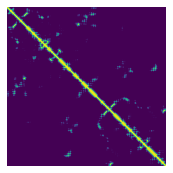

In [164]:
plt.figure(figsize = (probamap_c.shape[0]/100, probamap_c.shape[0]/100))
plt.axis("off")
plt.imshow(probamap_c)
plt.imsave("../data/19HCA/dataset_dir/data/map.png", probamap_c)

In [25]:
import tensorflow as tf
import os
import sys

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import os
import sys
import copy
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate, UpSampling2D

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from matplotlib.patches import Rectangle

In [2]:
def annot_header(folder,filename, path, size):
    header = f"<annotation>\n\t<folder>{folder}</folder>\n\t"\
    f"<filename>{filename}</filename>\n\t"\
    f"<path>{os.path.abspath(path)}</path>\n\t"\
    f"<size>\n\t\t<width>{size}</width>\n\t\t" \
    f"<height>{size}</height>\n\t\t" \
    "<depth>1</depth>\n\t</size>\n"
    
    return header
    
def annot_object(name,  xmin, xmax, truncated = 0, difficult = 0, occluded = 0):
    obj = f"\t<object>\n\t\t<name>{name}</name>\n\t\t" \
    f"<truncated>{truncated}</truncated>\n\t\t" \
    f"<difficult>{difficult}</difficult>\n\t\t"\
    f"<occluded>{occluded}</occluded>\n\t\t"\
    f"<bndbox>\n\t\t\t" \
    f"<xmin>{xmin}</xmin>\n\t\t\t" \
    f"<ymin>{xmin}</ymin>\n\t\t\t" \
    f"<xmax>{xmax}</xmax>\n\t\t\t" \
    f"<ymax>{xmax}</ymax>\n\t\t" \
    "</bndbox>\n\t</object>\n"
    return obj
    
def write_VOC(prot_name):
    file_log = f"../../data_peeling/{prot_name}/Peeling.log"
    PU_step = log_to_res(file_log)
    print(PU_step)
    step = sorted(PU_step[-1])
    with open(f"../data/Train/{prot_name}.xml", "w") as filout:
        arr = np.loadtxt(f"../data/{prot_name}/{prot_name}.mat")
        plt.imsave(f"../data/Train/{prot_name}.png", arr)
        
        image = cv2.imread(f"../data/Train/{prot_name}.png")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imsave(f"../data/Train/{prot_name}.png", image)
        
        filout.write(annot_header(f"{prot_name}",f"{prot_name}.mat",f"../data/{prot_name}/{prot_name}.mat", step[-1][-1]))
        for pos in step:
                filout.write(annot_object("PU", pos[0], pos[1]))

        filout.write("</annotation>")
        


In [116]:
def log_to_res(peeling_file_name):
    all_coords = []
    with open(peeling_file_name) as filin:
        for line in filin:
            if not line.startswith("#"):
                clean_coord = line.strip().split()[5:]
                xy = [[int(clean_coord[x]),int(clean_coord[x+1])] for x in range(0,len(clean_coord)-1,2)]
                all_coords.append(xy)
        return all_coords[-1]
    
def draw_cross(proba_map, point, min_limit, max_limit):
   
    # vertical
    proba_map[min_limit:max_limit+1, point] = 1

    # horizontal
    proba_map[point, min_limit:max_limit+1] = 1
    
    return proba_map

def draw_square(proba_map, x, y):
    for line in proba_map[x:y+1]:
        line[x:y+1] = 2

    return proba_map



def get_limit(x, dict_limit):
    max_value = sorted(dict_limit.keys())
    for value in max_value:
        if x <= value:
            return value
    
def draw_PU(proba_map, PU_step):
    min_limit = 0
    max_limit = proba_map.shape[0]
    dict_limit = {}
    first = True
    last = False
    for step in PU_step:
        if step ==  PU_step[-1]:
            last = False
            
        for pos in step:
            # residu 50 -> position 49 in matrix
            # DO REVERSE FOR REAL POS ! 49 --> 50 for PDB
            pos1 = pos[0] - 1
            pos2 = pos[1] - 1
            
            if last:
                proba_map = draw_cross(proba_map, pos2, min_limit, max_limit)
            else:

                
                if first:
                    proba_map = draw_cross(proba_map, pos2, min_limit, max_limit)
                    dict_limit[pos2] = pos1
                else:
                    max_limit = get_limit(pos2, dict_limit)
                    min_limit = dict_limit[max_limit]
                    proba_map = draw_cross(proba_map, pos2, min_limit, max_limit)
                    dict_limit[pos2] = pos1
        if first:
            first = False
    return proba_map

def draw_all_square(proba_map, PU_step):
    yellow = 1
    green = 1
    last = False
    for step in PU_step:
        if step == PU_step[-1]:
            last = True
        for pos in step:
            pos1 = pos[0] - 1
            pos2 = pos[1] - 1
            if last:
                proba_map[pos1,pos1:pos2+1] = green
                proba_map[pos1:pos2+1,pos1] = green
                proba_map[pos2,pos1:pos2+1] = green
                proba_map[pos1:pos2+1, pos2] = green
#             else:
#                 proba_map[pos1,pos1:pos2+1] = yellow
#                 proba_map[pos1:pos2+1,pos1] = yellow
#                 proba_map[pos2,pos1:pos2+1] = yellow
#                 proba_map[pos1:pos2+1, pos2] = yellow
        if last:
            last = False

#     proba_map[proba_map != 2] = 0
    return proba_map


        
def plot(proba_map):
    plt.figure(figsize = (10,5))
    plt.axis("off")
    plt.imshow(proba_map)
    
def process(prot_name):
    os.system(f"mkdir -p ../data/{prot_name}")
    file_map = f"../../data_peeling/{prot_name}/full_prob_map.mat"
    file_log = f"../../data_peeling/{prot_name}/Peeling.log"
    PU_step = log_to_res(file_log)
    proba_map = np.loadtxt(file_map)
    
    np.savetxt( f"../data/{prot_name}/{prot_name}.mat",proba_map, fmt = "%f")
#     plt.imsave(f"../data/{prot_name}/{prot_name}.png", proba_map)
    proba_map = draw_all_square(proba_map, PU_step)
    plt.imshow(proba_map)
    np.savetxt(f"../data/{prot_name}/{prot_name}_PU.mat",proba_map, fmt = "%d")
    
#     plt.imsave(f"../data/{prot_name}/{prot_name}_PU.png", proba_map)

    

In [80]:
def draw_square(image, PU):
    plt.imshow(image)
    # plt.title(f'Actual {i+4}')
    ax = plt.gca()
    # plot each box
    for i_box in range(len(PU)):
        # get coordinates
        x1, y1 = PU[i_box]
        # calculate width and height of the box
        size = y1 - x1
        # create the shape
        rect = Rectangle((x1, x1), size,size, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    return ax

In [95]:
def sword_check(image1, PU1, image2, PU2):
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.title("Peeling")
    plt.imshow(image1)
    # plt.title(f'Actual {i+4}')
    ax = plt.gca()
    # plot each box
    for i_box in range(len(PU1)):
        # get coordinates
        x1, y1 = PU1[i_box]
        # calculate width and height of the box
        size = y1 - x1
        # create the shape
        rect = Rectangle((x1, x1), size,size, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        
    plt.subplot(122)
    plt.imshow(image2)
    plt.title("Sword")
    
    # plt.title(f'Actual {i+4}')
    ax = plt.gca()
    # plot each box
    for i_box in range(len(PU2)):
        # get coordinates
        x1, y1 = PU2[i_box]
        # calculate width and height of the box
        size = y1 - x1
        # create the shape
        rect = Rectangle((x1, x1), size,size, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)


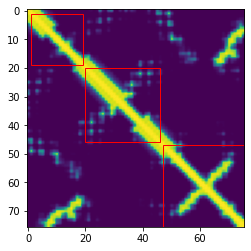

In [83]:
a = draw_square(proba_map, PU)

In [5]:
file_map = f"../../data_peeling/1DP7P/full_prob_map.mat"
file_log = f"../../data_peeling/1DP7P/Peeling.log"
PU_step = log_to_res(file_log)
proba_map = np.loadtxt(file_map)


In [336]:
for prot in prot_name[:5]:
    write_VOC(prot)

[[[1, 156], [157, 268], [269, 327]], [[269, 292], [293, 327], [1, 156], [157, 268]], [[1, 24], [25, 121], [122, 156], [269, 292], [293, 327], [157, 268]], [[122, 140], [141, 156], [1, 24], [25, 121], [269, 292], [293, 327], [157, 268]], [[157, 253], [254, 268], [122, 140], [141, 156], [1, 24], [25, 121], [269, 292], [293, 327]], [[293, 311], [312, 327], [157, 253], [254, 268], [122, 140], [141, 156], [1, 24], [25, 121], [269, 292]], [[25, 43], [44, 65], [66, 121], [293, 311], [312, 327], [157, 253], [254, 268], [122, 140], [141, 156], [1, 24], [269, 292]], [[157, 196], [197, 228], [229, 253], [25, 43], [44, 65], [66, 121], [293, 311], [312, 327], [254, 268], [122, 140], [141, 156], [1, 24], [269, 292]], [[66, 83], [84, 121], [157, 196], [197, 228], [229, 253], [25, 43], [44, 65], [293, 311], [312, 327], [254, 268], [122, 140], [141, 156], [1, 24], [269, 292]], [[197, 212], [213, 228], [66, 83], [84, 121], [157, 196], [229, 253], [25, 43], [44, 65], [293, 311], [312, 327], [254, 268], [

In [152]:
prot = "1AZCA"

In [171]:
proba_map = np.loadtxt(f"../../data_peeling/{prot}/full_prob_map.mat")

OSError: ../../data_peeling/1AZCA/full_prob_map.mat not found.

In [170]:
f = open(f"../sword/SWORD/PDBs_Clean/{prot}/file_proba_contact.mat")
pd.DataFrame(f.readlines())


,0
0,0.982 0.811 0.429 0.165 0.062 0.007 0.001 0.00...
1,0.811 0.982 0.825 0.548 0.170 0.022 0.003 0.0...
2,0.429 0.825 0.982 0.819 0.334 0.045 0.006 0.0...
3,0.165 0.548 0.819 0.982 0.821 0.345 0.060 0.0...
4,0.062 0.170 0.334 0.821 0.982 0.817 0.395 0.0...
...,...
226,0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.0...
227,0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.0...
228,0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.0...
229,0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.0...


TypeError: Image data of dtype <U1397824 cannot be converted to float

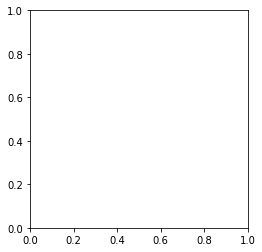

In [165]:
plt.imshow(p)

In [172]:
im_sword = np.loadtxt(f"../sword/SWORD/PDBs_Clean/{prot}/file_proba_contact.mat")

ValueError: Wrong number of columns at line 130

In [148]:
PU = log_to_res(f"../../data_peeling/{prot}/Peeling.log")

In [149]:
PU_sword = log_to_res(f"../sword/SWORD/PDBs_Clean/{prot}/Peeling/Peeling.log")

In [150]:
PU_sword[-1][-1]

271

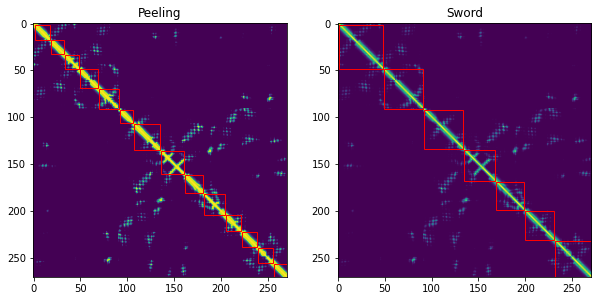

In [151]:
sword_check(proba_map,PU,im_sword, PU_sword)


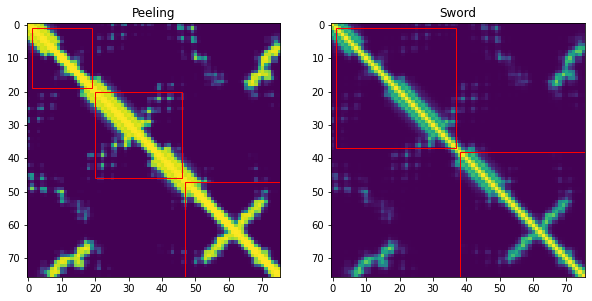

In [96]:
sword_check(proba_map,PU,im_sword, PU_sword)
